### Using the BiLSTM model with Attention from Class and the Yelp data create a train and test as we did in the lecture notes, changing the random seed of the split to 123.


### Load data

In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from livelossplot import PlotLossesKerasTF

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data = pd.read_csv('yelp.csv')

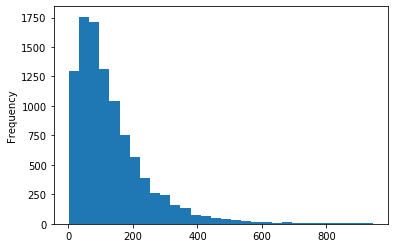

In [3]:
data.text.apply(lambda x: len(x.split())).plot.hist(bins = 30)

In [4]:
data.text.apply(lambda x: len(x.split())).describe()

count    10000.000000
mean       131.039600
std        113.584114
min          1.000000
25%         54.000000
50%        101.000000
75%        173.000000
max        945.000000
Name: text, dtype: float64

### Test train split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.text, 
                                                    data.stars, 
                                                    test_size = .2,
                                                    stratify = data.stars,
                                                    shuffle = True,
                                                    random_state = 123)

### Transforming the target variable

In [6]:
ytr = pd.get_dummies(y_train)
yte = pd.get_dummies(y_test)

In [7]:
print(y_train.shape)
print(ytr.shape)

(8000,)
(8000, 5)


In [8]:
ytr.head()

,1,2,3,4,5
7747,0,0,0,0,1
3863,0,1,0,0,0
4749,0,0,0,1,0
6742,0,0,1,0,0
5949,0,0,0,1,0


In [9]:
yte.head()

,1,2,3,4,5
4370,0,0,0,1,0
2642,1,0,0,0,0
994,0,0,1,0,0
8496,0,1,0,0,0
2122,0,0,0,1,0


### Preparing text for Tensorflow

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

In [12]:
len(tokenizer.word_index)

27857

In [13]:
tokenizer.num_words

10000

In [14]:
X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
pad_sequences([[i for i in range(50)]], maxlen = 32, padding='post', truncating = 'post')

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
      dtype=int32)

In [17]:
Xtr64 = pad_sequences(X_tr, maxlen = 64, padding='post', truncating = 'post')
Xte64 = pad_sequences(X_te, maxlen = 64, padding='post', truncating = 'post')

In [18]:
Xtr64.shape

(8000, 64)

In [19]:
def array_to_list(y_pred):
    return [np.argmax(y_pred[i,])+1 for i in range(y_pred.shape[0])]

### bi LSTM with Attention

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras import backend as K

In [21]:
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average attention mechanism from:
        Zhou, Peng, Wei Shi, Jun Tian, Zhenyu Qi, Bingchen Li, Hongwei Hao and Bo Xu.
        “Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification.”
        ACL (2016). http://www.aclweb.org/anthology/P16-2034
    How to use:
    see: [BLOGPOST]
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
         
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [22]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .5,
    'epochs': 20,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average ( (None, 128)               128       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
____________________________________________

In [23]:
def outputs(model):
    y_pred = array_to_list(model.predict(Xte64))
    print(classification_report(y_test, y_pred))
    print('\n')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print('\n')
    print(f'Accuracy: {np.trace(cm)}/{np.sum(cm)} = {100*np.trace(cm)/np.sum(cm)}')

In [24]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.05,
                momentum = 0.8,
                nesterov = True)

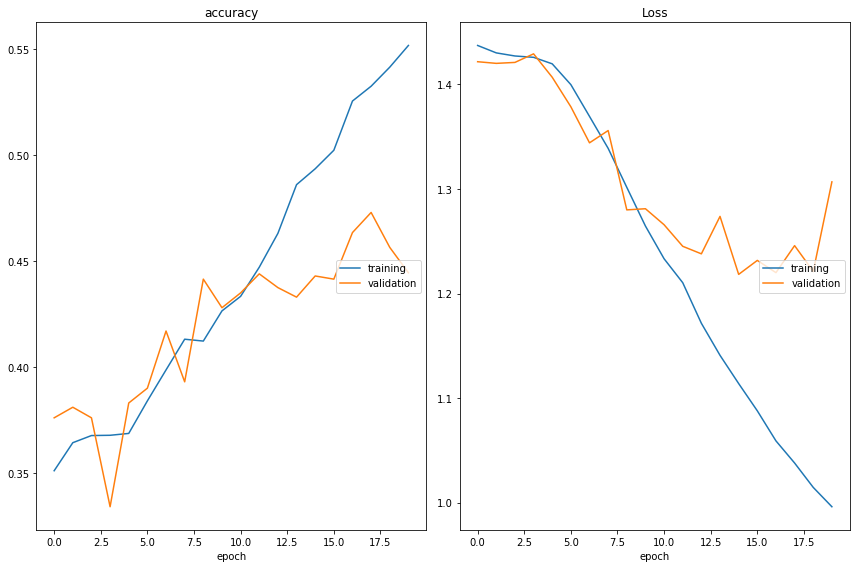

accuracy
	training         	 (min:    0.351, max:    0.552, cur:    0.552)
	validation       	 (min:    0.334, max:    0.473, cur:    0.444)
Loss
	training         	 (min:    0.996, max:    1.437, cur:    0.996)
	validation       	 (min:    1.218, max:    1.429, cur:    1.307)
250/250 [==============================] - 6s 25ms/step - loss: 0.9961 - accuracy: 0.5519 - val_loss: 1.3068 - val_accuracy: 0.4445
              precision    recall  f1-score   support

           1       0.57      0.39      0.47       150
           2       0.32      0.26      0.29       185
           3       0.27      0.47      0.34       292
           4       0.45      0.54      0.49       705
           5       0.67      0.40      0.50       668

    accuracy                           0.44      2000
   macro avg       0.46      0.41      0.42      2000
weighted avg       0.49      0.44      0.45      2000



[[ 59  32  33  20   6]
 [ 12  49  77  41   6]
 [ 10  31 137 103  11]
 [ 11  30 178 378 108]
 [ 11  

In [25]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

In [43]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .5,
    'epochs': 3,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average_1 (None, 128)               128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
____________________________________________

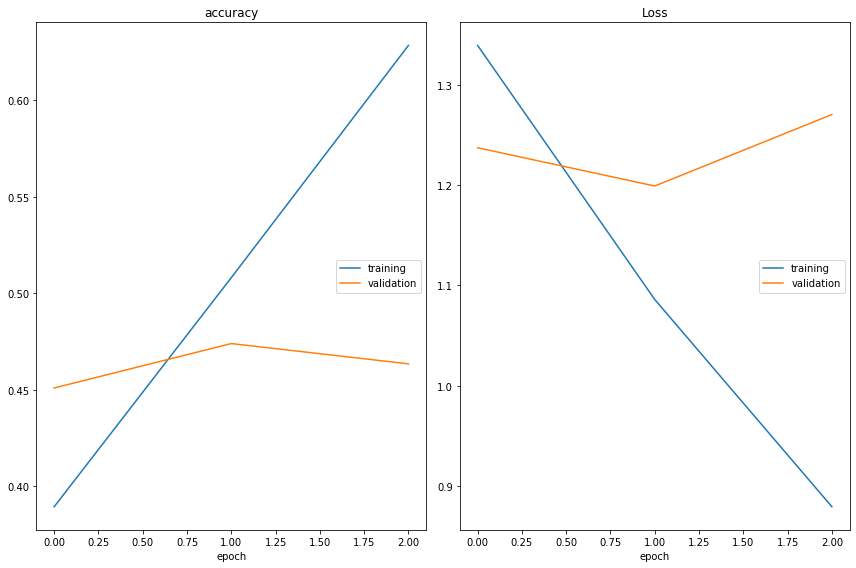

accuracy
	training         	 (min:    0.389, max:    0.628, cur:    0.628)
	validation       	 (min:    0.451, max:    0.474, cur:    0.463)
Loss
	training         	 (min:    0.879, max:    1.339, cur:    0.879)
	validation       	 (min:    1.199, max:    1.270, cur:    1.270)
250/250 [==============================] - 8s 30ms/step - loss: 0.8794 - accuracy: 0.6284 - val_loss: 1.2703 - val_accuracy: 0.4635
              precision    recall  f1-score   support

           1       0.60      0.37      0.46       150
           2       0.28      0.22      0.25       185
           3       0.30      0.28      0.29       292
           4       0.45      0.71      0.55       705
           5       0.67      0.36      0.47       668

    accuracy                           0.46      2000
   macro avg       0.46      0.39      0.40      2000
weighted avg       0.50      0.46      0.45      2000



[[ 56  40  23  24   7]
 [ 18  41  61  56   9]
 [  7  30  83 165   7]
 [  8  20  74 504  99]
 [  5  

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

### 1. What are the parameters being used in this process? Be sure to remember all parameters used at each step of the modeling process, including tokenization, training, and building the model. 

### my report on question 1

##### (1), Split the data into test and train. 

##### (2), Preparing text for tensorflow, which basically means to, first, tokenzide the data, cap the data into most common 10000 words, then pad the sqeuence, and create a sequence with length of 64.

##### (3), embed_size: we build the layer from the first layer which is the embedding layer, whcih takes 10000words to a smaller space. layer_size: a dense layer. dropout: connected to a drop out, randomly lose some of the neurons. output_size: a dense layer that is the full output of the model.

##### (4), then use stochatoc gradient descent, basically to randomly select n obervasions, calculate the value that is predicted for training set, the learning rate (lr)  is are we making big changes or small changes when we are incorrect, the momentum means the last several changes in our weight have been one direction, maybe we should lose that direction for the next chhange we make. SGD tends to have the best accuracy for our model, but it is significantly slower.

##### (5), configure the model with optimizer, and categorical_crossentropy loss function, also monitor the accuracy during the training by passing  accuracy to the metrics argument.

### 2. Using SGD train for 100 epochs at a learning rate of .01, .1, and 1. Use the momentum settings from class, and make sure to rerun the model assignment, compile, and fit for each run. Comment on the accuracy/loss charts and the final results. 

##### (1), lr = 0.01

In [28]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .5,
    'epochs': 100,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average_1 (None, 128)               128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
____________________________________________

In [29]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.01,
                momentum = 0.8,
                nesterov = True)

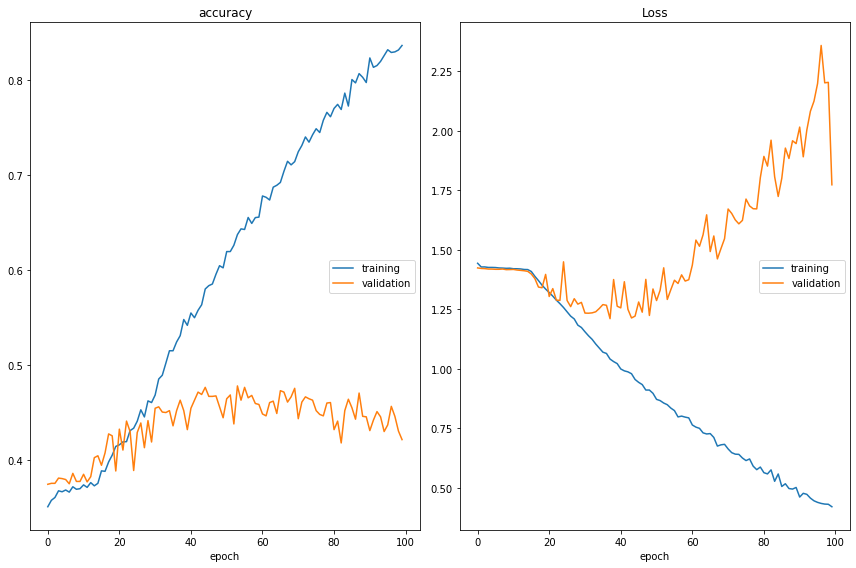

accuracy
	training         	 (min:    0.351, max:    0.836, cur:    0.836)
	validation       	 (min:    0.375, max:    0.478, cur:    0.421)
Loss
	training         	 (min:    0.421, max:    1.444, cur:    0.421)
	validation       	 (min:    1.211, max:    2.359, cur:    1.774)
250/250 [==============================] - 6s 23ms/step - loss: 0.4212 - accuracy: 0.8363 - val_loss: 1.7739 - val_accuracy: 0.4215
              precision    recall  f1-score   support

           1       0.64      0.18      0.28       150
           2       0.26      0.43      0.32       185
           3       0.31      0.29      0.30       292
           4       0.44      0.44      0.44       705
           5       0.51      0.52      0.51       668

    accuracy                           0.42      2000
   macro avg       0.43      0.37      0.37      2000
weighted avg       0.44      0.42      0.42      2000



[[ 27  68  18  12  25]
 [  9  79  31  38  28]
 [  3  61  85  98  45]
 [  1  59 106 307 232]
 [  2  

In [30]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

##### (2), lr = 0.1

In [32]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.1,
                momentum = 0.8,
                nesterov = True)

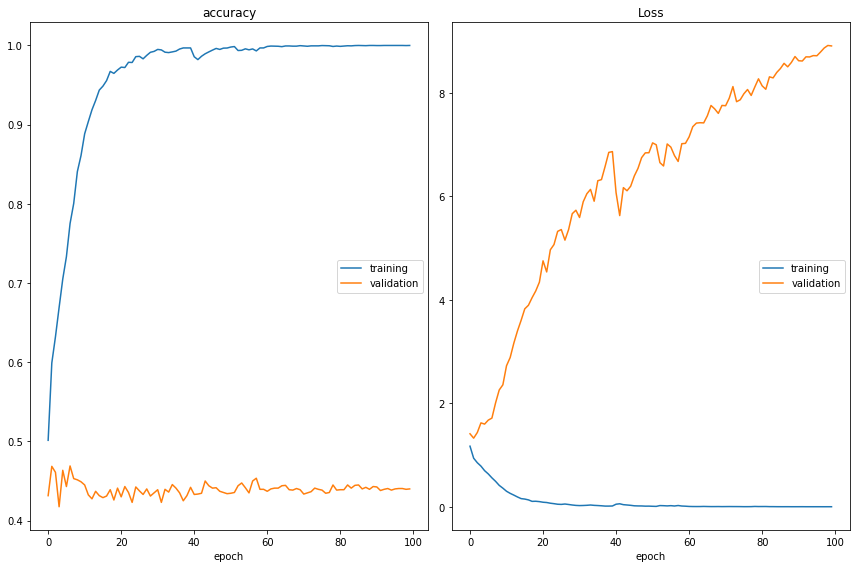

accuracy
	training         	 (min:    0.501, max:    1.000, cur:    1.000)
	validation       	 (min:    0.417, max:    0.469, cur:    0.440)
Loss
	training         	 (min:    0.001, max:    1.171, cur:    0.001)
	validation       	 (min:    1.326, max:    8.917, cur:    8.908)
250/250 [==============================] - 6s 23ms/step - loss: 5.8722e-04 - accuracy: 1.0000 - val_loss: 8.9078 - val_accuracy: 0.4400
              precision    recall  f1-score   support

           1       0.44      0.35      0.39       150
           2       0.27      0.31      0.29       185
           3       0.30      0.28      0.29       292
           4       0.47      0.50      0.48       705
           5       0.52      0.51      0.51       668

    accuracy                           0.44      2000
   macro avg       0.40      0.39      0.39      2000
weighted avg       0.44      0.44      0.44      2000



[[ 52  37  20  21  20]
 [ 25  57  46  30  27]
 [  8  48  81 106  49]
 [ 14  47  77 352 215]
 [ 

In [33]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

##### (3), lr = 1

In [34]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 1,
                momentum = 0.8,
                nesterov = True)

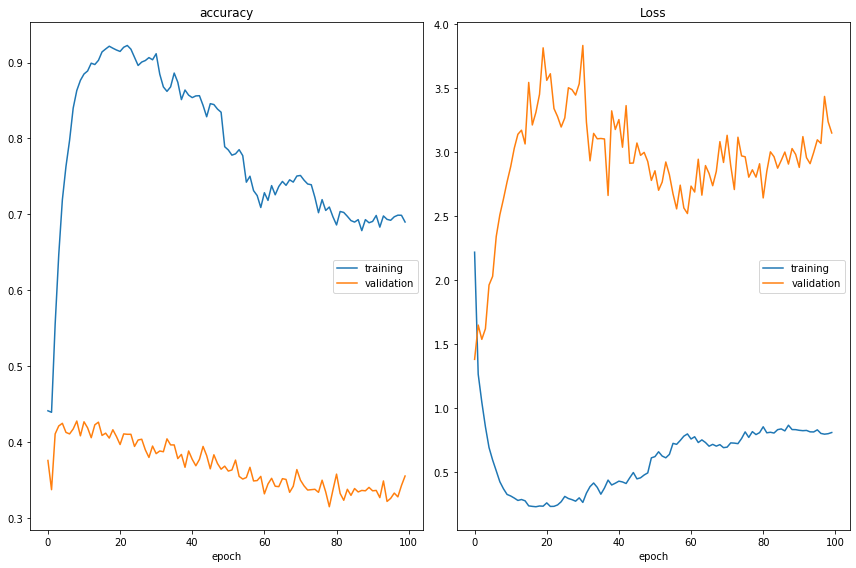

accuracy
	training         	 (min:    0.439, max:    0.923, cur:    0.690)
	validation       	 (min:    0.315, max:    0.428, cur:    0.355)
Loss
	training         	 (min:    0.227, max:    2.216, cur:    0.807)
	validation       	 (min:    1.379, max:    3.831, cur:    3.148)
250/250 [==============================] - 7s 27ms/step - loss: 0.8068 - accuracy: 0.6899 - val_loss: 3.1476 - val_accuracy: 0.3550
              precision    recall  f1-score   support

           1       0.21      0.11      0.14       150
           2       0.21      0.15      0.18       185
           3       0.17      0.07      0.10       292
           4       0.37      0.55      0.45       705
           5       0.41      0.38      0.40       668

    accuracy                           0.36      2000
   macro avg       0.27      0.25      0.25      2000
weighted avg       0.33      0.35      0.33      2000



[[ 16  19  11  69  35]
 [ 15  28  16  96  30]
 [ 10  18  20 157  87]
 [ 23  33  41 389 219]
 [ 14  

In [35]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

### my report on question 2

##### (1), when use learning rate = 0.1, the model has the best accuray which is about 44.0. when lr = 1, the result is the worst.

##### (2), the acurracy plot is the plot of accuracy on the training data and on the validation data. the loss plot is the penalty score for inaccuracy, this is something that penalizes large errors and small errors, which is basically just abstract measure of how confident it is on certain predictions.

##### (3),  from the accuracy plot we can see that there is a alrge divergence from training and validation data, we can see that for training data, the model is doing better and better, but the accuracy on validation data is getting worse after certain point, that is because, we have way more parameters than we have observations in this model, and in general, the more parameters we have, the closer we can fit the model, but you need more data, so we do not overfit.

##### (4), we can see from accuracy result that the most common mistakes are with things that are closer to it than things that are far away.

### 3. Using whichever learning rate performed best run the model using dropouts of .1, .5, and .9. Comment on the accuracy/loss charts and the final results.


##### (1), dropout of 0.1

In [39]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .1,
    'epochs': 100,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average_3 (None, 128)               128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
____________________________________________

In [40]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.1,
                momentum = 0.8,
                nesterov = True)

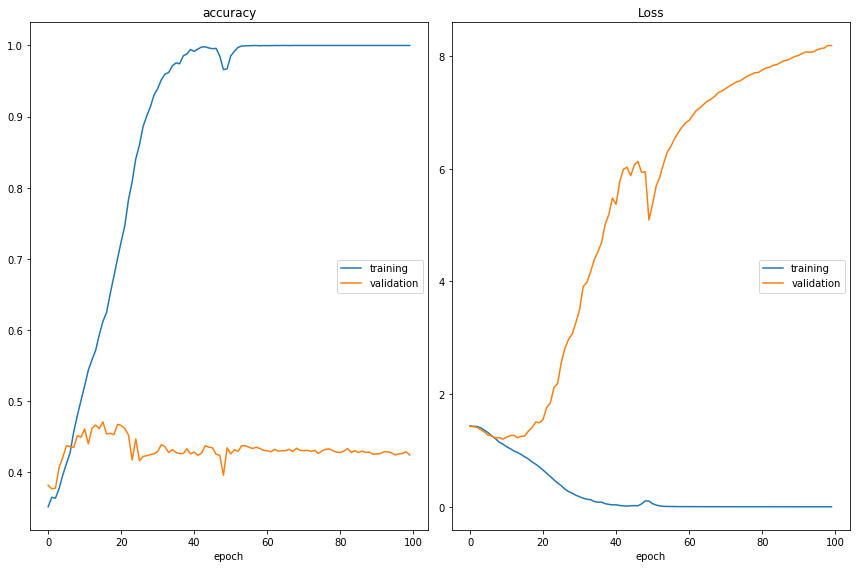

accuracy
	training         	 (min:    0.352, max:    1.000, cur:    1.000)
	validation       	 (min:    0.377, max:    0.471, cur:    0.424)
Loss
	training         	 (min:    0.000, max:    1.436, cur:    0.000)
	validation       	 (min:    1.200, max:    8.191, cur:    8.189)
250/250 [==============================] - 6s 23ms/step - loss: 3.6719e-04 - accuracy: 1.0000 - val_loss: 8.1891 - val_accuracy: 0.4245
              precision    recall  f1-score   support

           1       0.47      0.35      0.40       150
           2       0.23      0.26      0.25       185
           3       0.28      0.26      0.27       292
           4       0.44      0.49      0.46       705
           5       0.52      0.49      0.51       668

    accuracy                           0.42      2000
   macro avg       0.39      0.37      0.38      2000
weighted avg       0.43      0.42      0.42      2000



[[ 52  35  15  20  28]
 [ 19  48  49  44  25]
 [  8  51  77 122  34]
 [ 17  42  90 344 212]
 [ 

In [41]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

##### (2), dropout of 0.5

In [42]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .5,
    'epochs': 100,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average_4 (None, 128)               128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
____________________________________________

In [43]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.1,
                momentum = 0.8,
                nesterov = True)

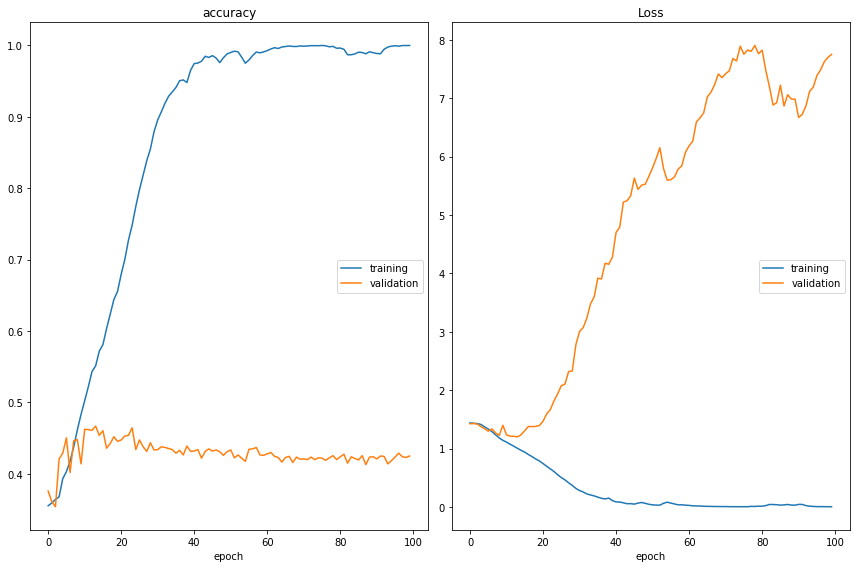

accuracy
	training         	 (min:    0.355, max:    1.000, cur:    1.000)
	validation       	 (min:    0.354, max:    0.467, cur:    0.425)
Loss
	training         	 (min:    0.003, max:    1.439, cur:    0.003)
	validation       	 (min:    1.200, max:    7.906, cur:    7.752)
250/250 [==============================] - 6s 24ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 7.7522 - val_accuracy: 0.4250
              precision    recall  f1-score   support

           1       0.43      0.33      0.38       150
           2       0.26      0.28      0.27       185
           3       0.31      0.30      0.31       292
           4       0.44      0.47      0.45       705
           5       0.51      0.49      0.50       668

    accuracy                           0.42      2000
   macro avg       0.39      0.38      0.38      2000
weighted avg       0.43      0.42      0.43      2000



[[ 50  40  16  21  23]
 [ 14  51  49  40  31]
 [ 13  41  89 117  32]
 [ 17  45  84 333 226]
 [ 22  

In [44]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

##### (3), dropout of 0.9

In [45]:
config = {
    'embed_size': 100,
    'layer_size': 64,
    'output_size': ytr.shape[1],
    'dropout': .9,
    'epochs': 100,
    'batch_size': 32,
}

def model_with_attention(train):
    inputs = Input(shape = (train.shape[1]))
    emb = Embedding(tokenizer.num_words, config['embed_size'])(inputs)
    bilstm = Bidirectional(LSTM(config['layer_size'], return_sequences = True))(emb)
    attn = AttentionWeightedAverage()(bilstm)
    dropout = Dropout(config['dropout'])(attn)
    output = Dense(config['output_size'], activation='softmax')(dropout)
    model = Model(inputs = [inputs], outputs = [output])
    return model

model = model_with_attention(Xtr64)

model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 64, 100)           1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64, 128)           84480     
_________________________________________________________________
attention_weighted_average_5 (None, 128)               128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 1,085,253
Trainable params: 1,085,253
Non-trainable params: 0
___________________________________________

In [46]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(lr = 0.1,
                momentum = 0.8,
                nesterov = True)

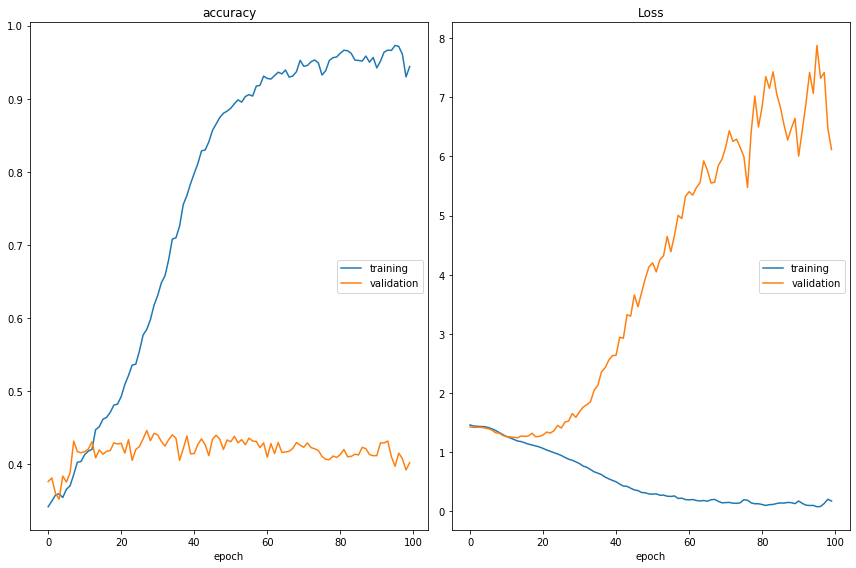

accuracy
	training         	 (min:    0.342, max:    0.973, cur:    0.944)
	validation       	 (min:    0.352, max:    0.446, cur:    0.402)
Loss
	training         	 (min:    0.080, max:    1.462, cur:    0.176)
	validation       	 (min:    1.246, max:    7.874, cur:    6.114)
250/250 [==============================] - 6s 25ms/step - loss: 0.1763 - accuracy: 0.9440 - val_loss: 6.1144 - val_accuracy: 0.4020
              precision    recall  f1-score   support

           1       0.51      0.27      0.35       150
           2       0.27      0.29      0.28       185
           3       0.23      0.30      0.26       292
           4       0.43      0.46      0.45       705
           5       0.51      0.44      0.47       668

    accuracy                           0.40      2000
   macro avg       0.39      0.35      0.36      2000
weighted avg       0.42      0.40      0.41      2000



[[ 41  38  30  30  11]
 [ 10  54  62  35  24]
 [  6  45  89 102  50]
 [ 14  43 125 324 199]
 [ 10  

In [47]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_losses = PlotLossesKerasTF()

history = model.fit(Xtr64, ytr.to_numpy(),
    batch_size = config['batch_size'],
    epochs=config['epochs'],
    validation_data=(Xte64, yte.to_numpy()),
    callbacks=[plot_losses])
outputs(model)

### my report on question 2

##### (1), we used drop out to help improve the model accuracy, prevent data from overfitting.

##### (2), when dropout = 0.5, we get the best result / accuracy.  when dropout =0.9, we get the worst result.

#####  (3), from the accuracy plot we can see that there is a alrge divergence from training and validation data, we can see that for training data, the model is doing better and better, but the accuracy on validation data is getting worse after certain point.

##### (4), we can see from accuracy result that the most common mistakes are with things that are closer to it than things that are far away.